# Project Desciption 


> Portobello Tech is an app innovator that has devised an intelligent way of predicting employee turnover within the company. It periodically evaluates employees' work details including the number of projects they worked upon, average monthly working hours, time spent in the company, promotions in the last 5 years, and salary level.

> Data from prior evaluations show the employee’s satisfaction at the workplace. The data could be used to identify patterns in work style and their interest to continue to work in the company. 

> The HR Department owns the data and uses it to predict employee turnover. Employee turnover refers to the total number of workers who leave a company over a certain time period.


## <font color='teal'>***Step 0: Import Libraries***

In [46]:
import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

## <font color='teal'>***Step 1: Import Dataset***

In [2]:
#read turnover dataset

df= pd.read_excel('turnover_dataset.xlsx')
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   sales                  14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


## <font color='teal'>***Step2: Data Cleaning & QA***

In [4]:
#For table

df.shape

(14999, 10)

In [5]:
#For rows
print('The number of missing cells is:', df.isna().sum().sum())
print('The number of duplicated rows are:', df.duplicated().sum())

The number of missing cells is: 0
The number of duplicated rows are: 3008


In [6]:
df.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')

In [7]:
df[df.duplicated()].groupby(by=['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary']).size().rename('count').reset_index()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary,count
0,0.09,0.62,6,294,4,0,1,0,accounting,low,2
1,0.09,0.77,5,275,4,0,1,0,product_mng,medium,2
2,0.09,0.77,6,290,4,0,1,0,technical,medium,2
3,0.09,0.78,6,254,4,0,1,0,support,low,2
4,0.09,0.79,6,275,4,0,1,0,sales,low,2
...,...,...,...,...,...,...,...,...,...,...,...
2333,1.00,0.86,2,264,3,0,0,0,IT,medium,1
2334,1.00,0.86,4,245,4,0,0,0,sales,medium,1
2335,1.00,0.88,6,201,4,0,0,0,technical,low,1
2336,1.00,0.93,5,167,3,0,0,0,sales,medium,1


<font color='red'> We see duplicated values here, however, I will keep those as maybe two empployees or more submited the same fact & figures

In [8]:
#for columns
#make all column names lower case

df.columns = df.columns.str.lower()

#Rename column sales into department
df.rename(columns={'sales':'department'}, inplace = True)

#Re-order column names 
df = df[['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5years', 'department', 'salary', 'left']]

In [9]:
#Now check if data is ready 
df.head(1)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,department,salary,left
0,0.38,0.53,2,157,3,0,0,sales,low,1


#### Now, we move to data wrangling then EDA

## <font color='teal'>***Step 3: Data Wrangling***

In [10]:
df.describe(include='all')

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,department,salary,left
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999,14999,14999.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,3,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,sales,low,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4140,7316,NaN
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,NaN,NaN,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,NaN,NaN,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,NaN,NaN,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,NaN,NaN,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,NaN,NaN,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,NaN,NaN,0.000000


#### The dataset is already clean so I will move to EDA to explore more

## <font color='teal'>***Step 4: EDA***
    

In [11]:
def without_hue(ax, feature):
    total = len(feature)
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)

''

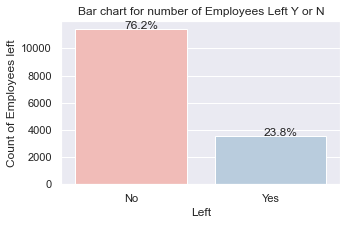

In [12]:
#Target
plt.figure(figsize=(5,3))
sns.set_theme(palette='Pastel1')
catp = sns.countplot(x='left', data=df)
catp.set_xlabel('Left')
catp.set_xticklabels (['No', 'Yes'])
catp.set_ylabel('Count of Employees left')
plt.title('Bar chart for number of Employees Left Y or N')

without_hue(catp, df.left)
;

<font color='red'> Based on the above, we infer that the data in un-balanced with percentage of 76% vs. 24%

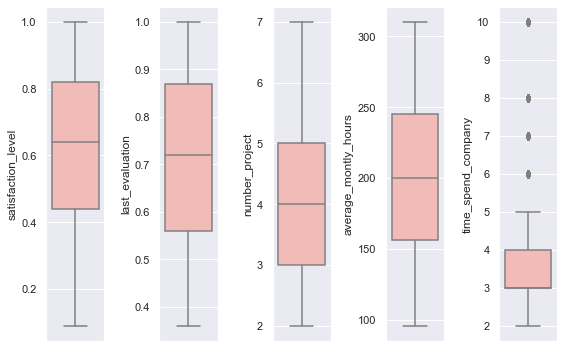

In [13]:
#Univariate plot to check distribution
numeric_cols = df.columns[:-5]
rows= 0
cols=0

fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(8,5))

for i in range(5):
    sns.boxplot(y=numeric_cols[i], data = df, ax=ax[cols])
#     if cols == 3:
#         rows=rows+1
#         cols=0
#     else: 
#         cols+=1
    cols+=1
    

plt.tight_layout()

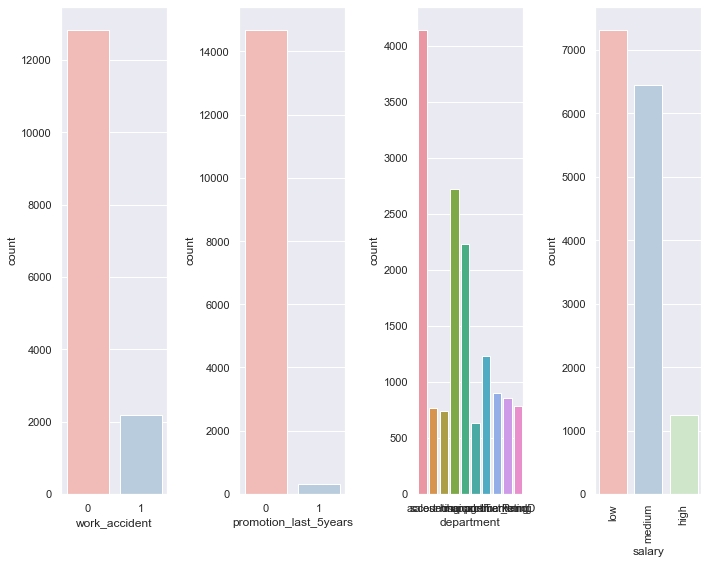

In [14]:
#Draw work_accident & promotion_last_5years
cat_cols = df.columns[-5:-1]
fig, ax =  plt.subplots(nrows=1, ncols=4, figsize=(10,8))

for i in range(4):
    catp = sns.countplot(x=cat_cols[i], data=df, ax=ax[i])
    if df[cat_cols[i]].nunique() > 2:
#         print(cat_cols[i])
        plt.xticks(rotation=90)
    
plt.tight_layout()


Based on uni-variate Analysis: 

1. Target is un-balanced and I plan to use SMOTE to treat this imbalance.
2. Only Salary in Numeric Features has outliers, but I will ignore and keep them. 
3. For Categorical & Binary columns, there are imbalance but since this is feature, no remedy is required. 

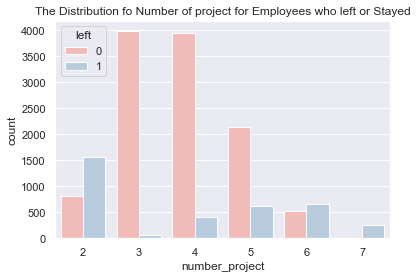

In [15]:
# Bivariate Plot for Eployee project count & Left

# fig, ax = plt.subplots(nrows=1, ncols=2)
sns.countplot(x='number_project', data=df, hue='left')
plt.title('The Distribution fo Number of project for Employees who left or Stayed');

- The Employees who left take more project than those who still didnt leave.
- Employees who left their distribution is skewed to *Right* 
- Employees who didnt leave their distribution is Normal.

***Please note that the Data is imbalanced, that's why the bars for those who didnt leave is much taller***

<AxesSubplot:>

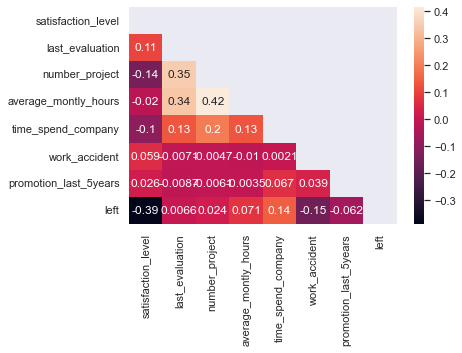

In [16]:
#Multi-variate plot
mask = np.triu(np.ones_like(df.corr(), dtype=bool))
sns.heatmap(df.corr(), annot=True, mask=mask)

## <font color='teal'>***Step 5: Model Development***

#### Model 1: Kmeans Clustering

Data preparation for Clustering:

- No normalization required as both column range from 0~1
- Target is already encoded in 0 + 1

In [17]:
cluster_df = df[['satisfaction_level', 'last_evaluation', 'left']].values
#Model Activation
km = KMeans(n_clusters=3)
#model train
km.fit(X=cluster_df)
#Model Evalution
print('The KMeans Model Inertia is ', km.inertia_)

C:\Users\emarelm\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


The KMeans Model Inertia is  867.9678337640868


## Handling Class Imbalance using SMOTE

4.1.	Pre-Process the data by converting categorical columns to numerical columns by
- Separating categorical variables and numeric variables.
- Applying get_dummies() to the categorical variables.
- Combining categorical variables and numeric variables.
- Do the stratified split of the dataset to train and test in the ratio 80:20 with random_state=123.
- Upsample the train dataset using SMOTE technique from the imblearn module.


In [18]:
df_cat = df[['department','salary']]

df_cat=pd.get_dummies(df_cat)

master_df = pd.concat([df, df_cat], axis=1).drop(columns=['department','salary'])

In [ ]:
# Split Data into X & y
X = master_df.drop(columns='left')
Y = master_df.left

#Split Data into Train & test 
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, stratify=Y, random_state=123)

#Upsample Train Data using SMOTE
oversample = SMOTE()
transformed_feature_df, transformed_label_df = oversample.fit_resample(X_train, y_train)

5.	Perform 5-Fold cross-validation model training and evaluate performance. 
- Train a Logistic Regression model and apply a 5-Fold CV and plot the classification report.
- Train a Random Forest Classifier model and apply the 5-Fold CV and plot the classification report.
- Train a  Gradient Boosting Classifier model and apply the 5-Fold CV and plot the classification report.


In [43]:
#Create 5-Kfold on training Data
kfold = KFold(n_splits=5, random_state=7, shuffle=True)

#Model Activation 
lr = LogisticRegression()
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

#Modelt Train & Evaluate  on Folds 
lr_results = cross_val_score(lr, transformed_feature_df, transformed_label_df , cv=kfold)
rf_results = cross_val_score(rf,transformed_feature_df, transformed_label_df , cv=kfold)
gb_results = cross_val_score(gb, transformed_feature_df, transformed_label_df , cv=kfold)


#Model Score 
print('The Average Accuracy for Logistic Regression Model on 5-Kfolds is:', lr_results.mean())
print('The Average Accuracy for Random Forest Model on 5-Kfolds is:', rf_results.mean())
print('The Average Accuracy for Gradient Boosting Model on 5-Kfolds is:', gb_results.mean())



The Average Accuracy for Logistic Regression Model on 5-Kfolds is: 0.7970904993810018
The Average Accuracy for Random Forest Model on 5-Kfolds is: 0.9827719567820236
The Average Accuracy for Gradient Boosting Model on 5-Kfolds is: 0.9609494007176668


6.	Identify the best model and justify the evaluation metrics used. 
- Find the ROC/AUC for each model and plot the ROC curve.
- Find the confusion matrix for each of the models.
- From the confusion matrix, explain which metric needs to be used- Recall or Precision?


In [51]:
# generate y_pred

#Logistic Model
lr.fit(transformed_feature_df, transformed_label_df)
y_pred_lr = lr.predict(X_test)

# Random FOrest Model
rf.fit(transformed_feature_df, transformed_label_df)
y_pred_rf = rf.predict(X_test)

#Gradient Boosted Model
gb.fit(transformed_feature_df, transformed_label_df)
y_pred_gb = gb.predict(X_test)


print ("\n\n ---Logistic Model---")
gbc_auc = roc_auc_score(y_test, y_pred_lr)
print ("Logistic Classifier AUC = %2.4f" % gbc_auc)
print(classification_report(y_test, y_pred_lr))

print ("\n\n ---Random Forest Model---")
gbc_auc = roc_auc_score(y_test, y_pred_rf)
print ("Random Forest Classifier AUC = %2.4f" % gbc_auc)
print(classification_report(y_test, y_pred_rf))

print ("\n\n ---Gradient Boosting Model---")
gbc_auc = roc_auc_score(y_test,y_pred_gb )
print ("Gradient Boosting Classifier AUC = %2.4f" % gbc_auc)
print(classification_report(y_test,y_pred_gb))



 ---Logistic Model---
Logistic Classifier AUC = 0.7742
              precision    recall  f1-score   support

           0       0.92      0.77      0.84      2286
           1       0.51      0.78      0.62       714

    accuracy                           0.77      3000
   macro avg       0.71      0.77      0.73      3000
weighted avg       0.82      0.77      0.78      3000



 ---Random Forest Model---
Random Forest Classifier AUC = 0.9835
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2286
           1       0.97      0.98      0.97       714

    accuracy                           0.99      3000
   macro avg       0.98      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



 ---Gradient Boosting Model---
Gradient Boosting Classifier AUC = 0.9549
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2286
           1       0.92      0.94     

- Based on Precision & Recall: Logistic Regression is worest performing as It always predict 0 better than 1 while RF & GB dont experience that..!

In [69]:
def plot_roc_curve(fper, tper):  
    plt.plot(fper, tper, color='orange', label='ROC', , labels=['Logistic Regression', 'Random Forest', ' Gradient Boosting'])
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
#     plt.show()

SyntaxError: invalid syntax (1127141072.py, line 2)

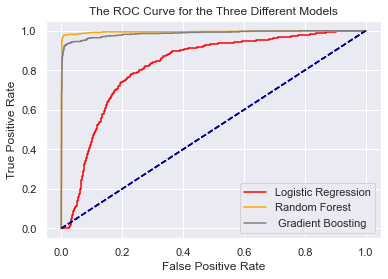

In [76]:
models = [lr, rf, gb]
model_name = ['Logistic Regression', 'Random Forest', ' Gradient Boosting']
colors = ['red', 'orange', 'grey']
# fig, ax = plt.subplots(nrows = 1, ncols=3)
for i in range(3):
    model = models[i]
    probs = model.predict_proba(X_test)  
    probs = probs[:, 1]  
    fper, tper, thresholds = roc_curve(y_test, probs) 
#     plt.subtitles(model_name[i] + 'Receiver Operating Characteristic (ROC) Curve')
    plt.plot(fper, tper, color=colors[i], label=model_name[i])
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', )
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('The ROC Curve for the Three Different Models')
    plt.legend()

7.	Suggest various retention strategies for targeted employees.
- Using the best model, predict the probability of employee turnover in the test data.
- Based on the below probability score range, categorize the employees into four zones and suggest your thoughts on the retention strategies for each zone.
>■	Safe Zone (Green) (Score < 20%)
■	Low Risk Zone (Yellow) (20% < Score < 60%)
■	Medium Risk Zone (Orange) (60% < Score < 90%)
■	High Risk Zone (Red) (Score > 90%).


<font color='red'> ***According to Confusion Matrix (f1-Score) and ROC curve, the best model is Random Forest.***

In [86]:
#Create prediction using random forest for turnover probabilities
y_pred_proba = rf.predict_proba(X_test)[:,1]

In [95]:
# Create a scoring system based on predict proba of test
scores = []
for i in range(len(y_pred_proba)):
    turnover_prob = y_pred_proba[i]
    if turnover_prob <= 0.2: 
        scores.append('green')
    elif 0.2 <turnover_prob <= 0.6:
        scores.append('yellow')
    elif 0.6 <turnover_prob <=0.9:
        scores.append('orange')
    else: 
        scores.append('red')

In [100]:
test_data.scores.value_counts()

green     2156
red        643
yellow     137
orange      64
Name: scores, dtype: int64

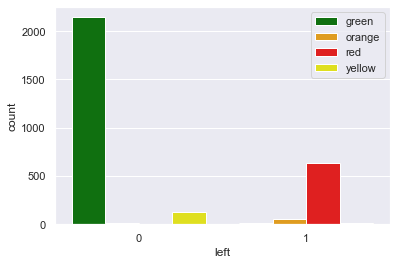

In [106]:
X_test['scores'] = scores
test_data = pd.concat([X_test, y_test], axis=1)

sns.countplot(x='left', data = test_data, hue=scores,  palette=['green', 'orange', 'red', 'yellow', ] );